<a href="https://colab.research.google.com/github/Howard-203/howard/blob/master/dog_human_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/content/drive/MyDrive/AI/dataset/lfw/*/*"))#/content/drive/MyDrive/AI/dataset/lfw
dog_files = np.array(glob("/content/drive/MyDrive/AI/dataset/dogImages/*/*/*"))#/content/drive/MyDrive/AI/dataset/dogImages

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 8484 total human images.
There are 8351 total dog images.


Number of faces detected: 1


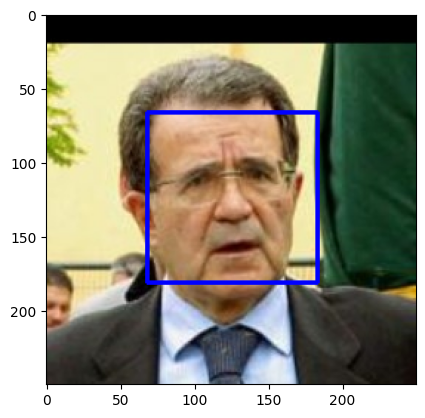

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/AI/dataset/haarcascade_frontalface_alt.xml')
#/content/drive/MyDrive/AI/dataset/haarcascade_frontalface_alt.xml
# load color (BGR) image
img = cv2.imread(human_files[100])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [4]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

Oops, really? no human on this image?


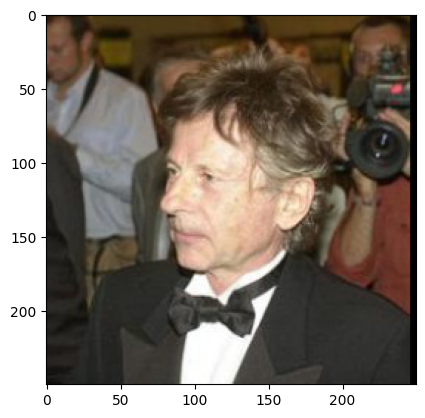

Humans detected as humans: 99 of 100; (expected: 100)
Dog recognized as a human


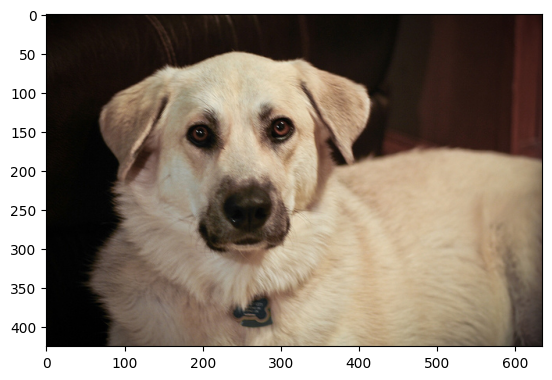

Dog recognized as a human


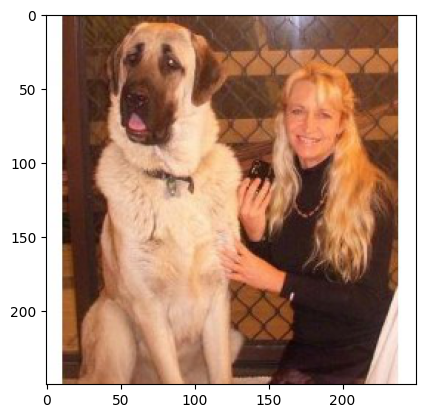

Dog recognized as a human


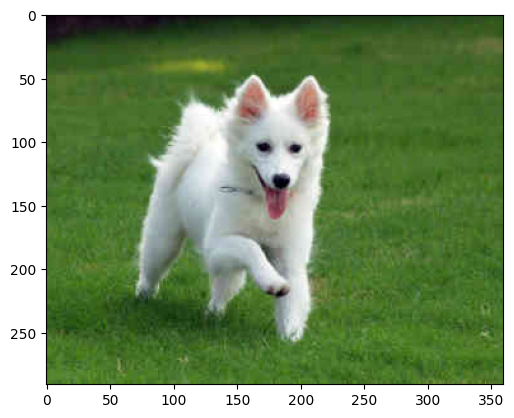

Dog recognized as a human


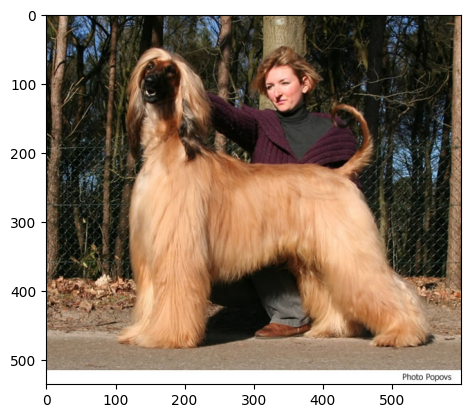

Dog recognized as a human


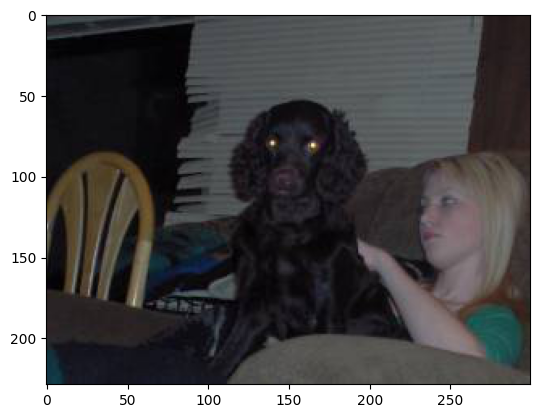

Dog recognized as a human


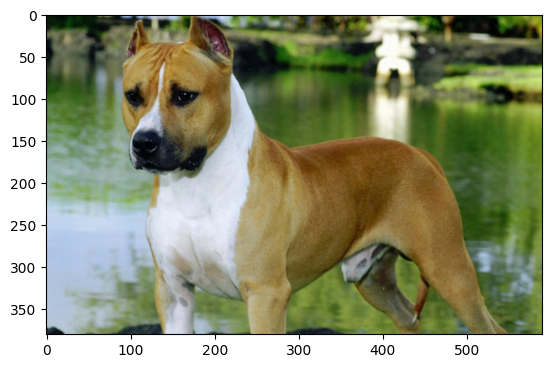

Dog recognized as a human


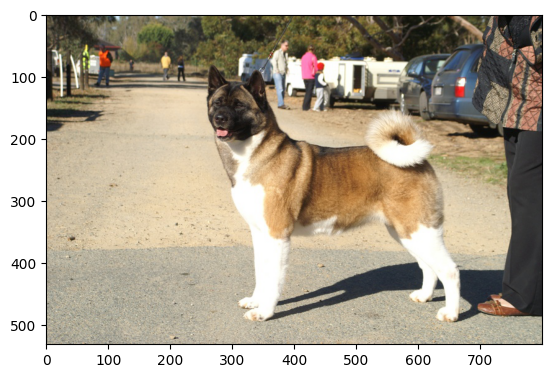

Dog recognized as a human


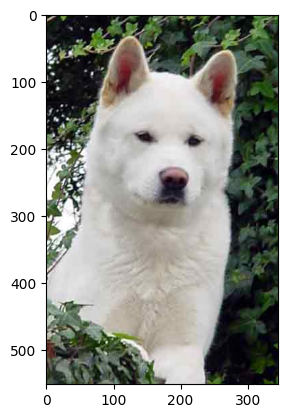

Dog recognized as a human


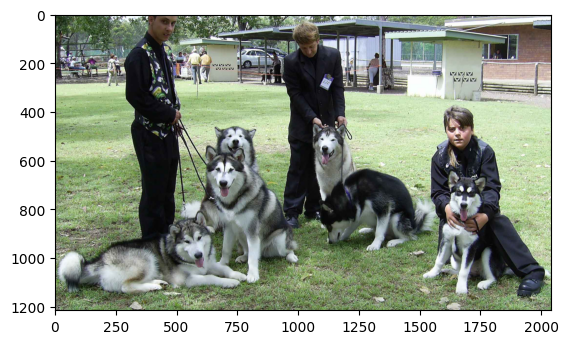

Dog recognized as a human


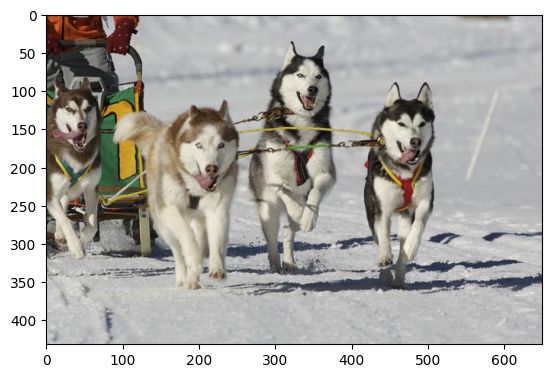

Dog recognized as a human


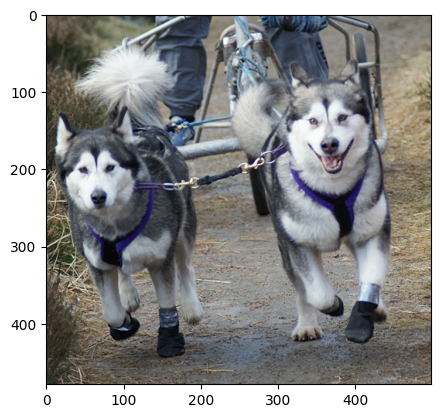

Dog recognized as a human


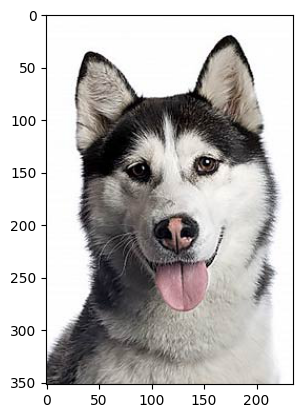

Dog recognized as a human


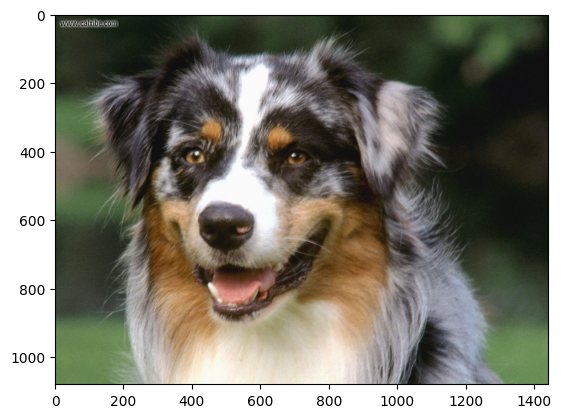

Dog recognized as a human


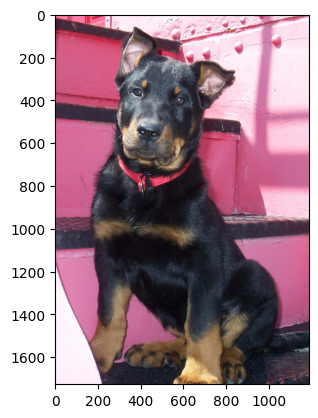

Dog recognized as a human


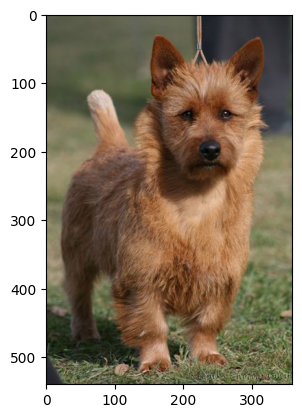

Dogs detected as humans: 15 of 100; (expected: 0)


In [5]:
from PIL import Image
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

human_as_human_num = 0
for human_file in human_files_short:
    if face_detector(human_file):
        human_as_human_num += 1
    else: 
        # show human image that was not correctly recognized
        print('Oops, really? no human on this image?')
        incorrectly_classified = Image.open(human_file)
        plt.imshow(incorrectly_classified)
        plt.show()
        
print('Humans detected as humans: {} of 100; (expected: 100)'.format(human_as_human_num))

dogs_as_human_num = 0
for dog_file in dog_files_short:
    if face_detector(dog_file):
        dogs_as_human_num += 1
        # show the ~werewolf~ human dog
        print("Dog recognized as a human")
        incorrectly_classified = Image.open(dog_file)
        plt.imshow(incorrectly_classified)
        plt.show()
        
        
#Cannot use formatted strings like this as AWS VM uses Python 3.5: f'Dogs detected as humans: {dogs_as_human_num} of 100; (expected: 0)'
print('Dogs detected as humans: {} of 100; (expected: 0)'.format(dogs_as_human_num))

In [6]:
import torch

# check if CUDA is available
use_cuda = torch.cuda.is_available()
# Make sure that CUDA is still available :) 
# One time, I waited for 30 minutes to run a single epoch, only to find out that
# CUDA was not available 
print('use_cuda:', use_cuda)

use_cuda: True


In [7]:
torch.cuda.empty_cache()

In [8]:
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 243MB/s]


In [9]:
from PIL import Image
import torchvision.transforms as transforms

def image_to_tensor(img):
    transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    
    image_tensor = transform(img)
    return image_tensor.unsqueeze(0)

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    image_tensor = image_to_tensor(Image.open(img_path)) 
    if use_cuda:
        image_tensor = image_tensor.cuda()
        
    predicted = VGG16(image_tensor)
    if use_cuda:
        predicted = predicted.cpu()
    
    predicted = predicted.data.numpy().argmax()
    
    return predicted # predicted class index

In [10]:
def dog_detector(img_path):
    predicted_class = VGG16_predict(img_path)
    # VGG16 distinguishes 118 (== 268-151+1) dog breeds
    return 151 <= predicted_class and predicted_class <= 268 

In [11]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

humans_detected_as_dog = filter(lambda x : dog_detector(x), human_files_short)
human_as_dog_num = len(list(humans_detected_as_dog))
        
print('Humans detected as dogs: {}%'.format(human_as_dog_num))

# Similar thing, implemented with lambdas. More readable!
dogs_detected_as_dog = filter(lambda x : dog_detector(x), dog_files_short)
dogs_as_dog_num = len(list(dogs_detected_as_dog))

print('Dogs detected as dogs: {}%'.format(dogs_as_dog_num)) # can use as per cents as dog_files_short has 100 items

Humans detected as dogs: 0%
Dogs detected as dogs: 96%


In [12]:
import os
from torchvision import datasets
import torchvision.transforms as transforms

num_workers = 0
batch_size = 32

# Normalizer from https://pytorch.org/docs/stable/torchvision/models.html
image_normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# In my first 1000 revisions, I called it simply `transforms`.
# Big mistake! It overrode `import torchvision.transforms as transforms`
image_transforms = {
    'train':  transforms.Compose([
        transforms.RandomHorizontalFlip(), # default p=0.5
        transforms.RandomRotation(10),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        image_normalizer ]),
    # no need to flip or rotate in validation and test sets
    'valid':  transforms.Compose([ 
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        image_normalizer ]),
    'test':  transforms.Compose([
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        image_normalizer ])

}

loaders_scratch = {}

dog_images_dir = '/content/drive/MyDrive/AI/dataset/dogImages'#/content/drive/MyDrive/AI/dataset/dogImages

for loader_type in ['train', 'valid', 'test']:
    dataset = datasets.ImageFolder(os.path.join(dog_images_dir, loader_type), transform=image_transforms[loader_type])
    # shuffle=True is essential here, without a batch would consist of mostly photos of the same breed
    loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
    loaders_scratch[loader_type]=loader

dog_classes = loaders_scratch['train'].dataset.classes

In [13]:
print('The training dataset defines {} classes for dog breeds'.format(len(dog_classes)))

The training dataset defines 133 classes for dog breeds


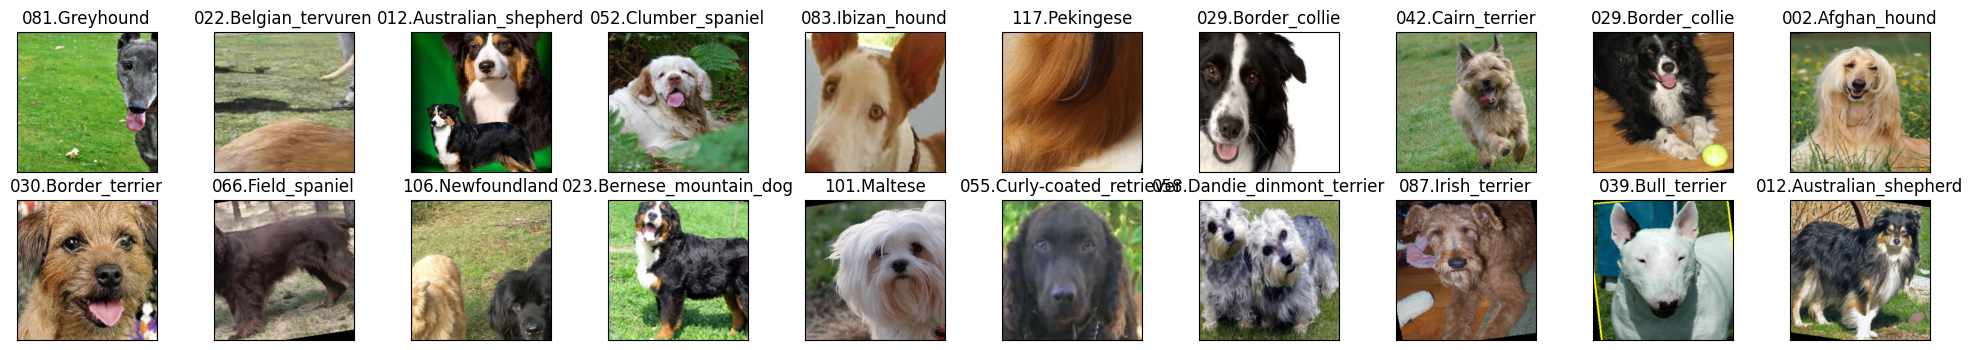

In [14]:
import matplotlib.pyplot as plt                        
%matplotlib inline  


def tensor_to_image(tensor):
    tensor = tensor #.to("cpu").clone().detach()
    tensor = tensor.numpy().squeeze()
    image = tensor.transpose(1,2,0)
    # revert transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

images, labels = next(iter(loaders_scratch['train']))

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(tensor_to_image(images[idx]))
    ax.set_title(dog_classes[labels[idx]])

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        # takes 224x224x3
        self.conv1_1 = nn.Conv2d(3, 32, 3, padding=1)
        
        # takes 224/2 = 112 ->    112x112x32
        self.conv2_1 = nn.Conv2d(32, 64, 3, padding=1)
        
        # takes 112/2= 56
        self.conv3_1 = nn.Conv2d(64, 128, 3, padding=1)
        
        # takes 56/2= 28
        self.conv4_1 = nn.Conv2d(128, 256, 3, padding=1)
        
        # takes 28/2= 14
        self.conv5_1 = nn.Conv2d(256, 512, 3, padding=1)
        
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512*7*7, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 133)
        
        self.dropout = nn.Dropout(0.30)
    
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = self.pool(x)

        x = F.relu(self.conv2_1(x))
        x = self.pool(x)

        x = F.relu(self.conv3_1(x))
        x = self.pool(x)

        x = F.relu(self.conv4_1(x))
        x = self.pool(x)
        
        x = F.relu(self.conv5_1(x))
        x = self.pool(x)

        x = x.view(-1, 512*7*7)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))

        x = self.dropout(x)
        x = F.relu(self.fc2(x))

        x = self.dropout(x)
        x = self.fc3(x)
        
        return x
    

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# Modified weight initialization here. Made it worse!! 
# model_scratch.apply(weights_init_normal)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [16]:
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

In [17]:
import time

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        print("Starting training in epoch: ", epoch)
        start_time = time.time()
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for (data, target) in loaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
         
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for (data, target) in loaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the validation loss
            output = model(data)
            valid_loss += criterion(output, target).item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
        print('Epoch {} took {} seconds \n'.format(epoch, time.time()-start_time))    
            
    # return trained model
    return model

In [18]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# train the model
model_scratch = train(5, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Starting training in epoch:  1
Epoch: 1 	Training Loss: 4.893766 	Validation Loss: 4.869592
Validation loss decreased (inf --> 4.869592).  Saving model ...
Epoch 1 took 3457.913489341736 seconds 

Starting training in epoch:  2
Epoch: 2 	Training Loss: 4.789164 	Validation Loss: 4.672510
Validation loss decreased (4.869592 --> 4.672510).  Saving model ...
Epoch 2 took 129.4963574409485 seconds 

Starting training in epoch:  3
Epoch: 3 	Training Loss: 4.696620 	Validation Loss: 4.636241
Validation loss decreased (4.672510 --> 4.636241).  Saving model ...
Epoch 3 took 129.33291578292847 seconds 

Starting training in epoch:  4
Epoch: 4 	Training Loss: 4.614702 	Validation Loss: 4.504689
Validation loss decreased (4.636241 --> 4.504689).  Saving model ...
Epoch 4 took 128.25438141822815 seconds 

Starting training in epoch:  5
Epoch: 5 	Training Loss: 4.530028 	Validation Loss: 4.439793
Validation loss decreased (4.504689 --> 4.439793).  Saving model ...
Epoch 5 took 129.15115356445312 se

In [19]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
model_scratch = train(5, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Starting training in epoch:  1
Epoch: 1 	Training Loss: 4.470775 	Validation Loss: 4.306269
Validation loss decreased (inf --> 4.306269).  Saving model ...
Epoch 1 took 130.56487607955933 seconds 

Starting training in epoch:  2
Epoch: 2 	Training Loss: 4.373928 	Validation Loss: 4.260790
Validation loss decreased (4.306269 --> 4.260790).  Saving model ...
Epoch 2 took 129.65316605567932 seconds 

Starting training in epoch:  3
Epoch: 3 	Training Loss: 4.306113 	Validation Loss: 4.205700
Validation loss decreased (4.260790 --> 4.205700).  Saving model ...
Epoch 3 took 128.45616340637207 seconds 

Starting training in epoch:  4
Epoch: 4 	Training Loss: 4.241215 	Validation Loss: 4.161415
Validation loss decreased (4.205700 --> 4.161415).  Saving model ...
Epoch 4 took 128.9731888771057 seconds 

Starting training in epoch:  5
Epoch: 5 	Training Loss: 4.198737 	Validation Loss: 4.106435
Validation loss decreased (4.161415 --> 4.106435).  Saving model ...
Epoch 5 took 128.56933736801147 s

In [20]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

In [21]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [22]:
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.050315


Test Accuracy:  7% (65/836)


In [23]:
# Borrowed from above for convenience so I could run the Transfer Learning starting from this cell
import torchvision.transforms as transforms
import numpy as np
import torch

import os
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

use_cuda = torch.cuda.is_available()

num_workers = 0
batch_size = 20

image_normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transforms = {
    'train':  transforms.Compose([
        transforms.RandomHorizontalFlip(), # default p=0.5
        transforms.RandomRotation(20),
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        image_normalizer ]),
    'valid':  transforms.Compose([ # no flipping or rotating
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        image_normalizer ]),
    'test':  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        image_normalizer ])

}

loaders_transfer = {}

dog_images_dir = '/content/drive/MyDrive/AI/dataset/dogImages'

for loader_type in ['train', 'valid', 'test']:
    dataset = datasets.ImageFolder(os.path.join(dog_images_dir, loader_type), image_transforms[loader_type])
    # shuffle=True is essential here, without it there will be photos of the same breed in a batch
    loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
    loaders_transfer[loader_type]=loader

dog_classes = loaders_transfer['train'].dataset.classes

In [24]:
import torchvision.models as models
import torch.nn as nn

# VGG16 and VGG19 didn't show good results. Try ResNet50
model_transfer = models.resnet50(pretrained=True)
print(model_transfer)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 28.1MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
for param in model_transfer.parameters():
    param.requires_grad = False
    
n_inputs = model_transfer.fc.in_features    
last_layer = nn.Linear(n_inputs, len(dog_classes))

model_transfer.fc = last_layer

print(model_transfer)
    
if use_cuda:
    model_transfer = model_transfer.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
# Both SGD and Adam are appropriate for probabilistic classifiers
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr = 0.001)

In [28]:
n_epochs = 10
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Starting training in epoch:  1
Epoch: 1 	Training Loss: 1.072584 	Validation Loss: 0.808546
Validation loss decreased (inf --> 0.808546).  Saving model ...
Epoch 1 took 155.25535011291504 seconds 

Starting training in epoch:  2
Epoch: 2 	Training Loss: 0.647095 	Validation Loss: 0.699406
Validation loss decreased (0.808546 --> 0.699406).  Saving model ...
Epoch 2 took 154.4333062171936 seconds 

Starting training in epoch:  3
Epoch: 3 	Training Loss: 0.523880 	Validation Loss: 0.641311
Validation loss decreased (0.699406 --> 0.641311).  Saving model ...
Epoch 3 took 155.04913449287415 seconds 

Starting training in epoch:  4
Epoch: 4 	Training Loss: 0.484330 	Validation Loss: 0.670549
Epoch 4 took 155.8629355430603 seconds 

Starting training in epoch:  5
Epoch: 5 	Training Loss: 0.423319 	Validation Loss: 0.620004
Validation loss decreased (0.641311 --> 0.620004).  Saving model ...
Epoch 5 took 155.1687469482422 seconds 

Starting training in epoch:  6
Epoch: 6 	Training Loss: 0.3819

In [29]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [30]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.578249


Test Accuracy: 83% (695/836)


In [31]:
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_tensor = image_to_tensor(Image.open(img_path)) 
    if use_cuda:
        image_tensor = image_tensor.cuda()
        
    output = model_transfer(image_tensor)
    
    probabilities = F.softmax(output, dim=1).data
    
    if use_cuda:
        probabilities = probabilities.cpu() # move to cpu

    
    top_probabilities, top_indices = probabilities.topk(3)
    top_probabilities = top_probabilities.numpy().squeeze()
    top_indices = top_indices.numpy().squeeze()
    return (top_probabilities, top_indices)
    
def breed_summary(predictions):
    probabilities, indices = predictions
    summary = ""
    for (prob, index) in zip(probabilities, indices):
        summary += "\t{}: {:.2f}% \n".format(class_names[index], prob*100)
        
    return summary
    

In [32]:
def run_app(img_path):
    plt.imshow(Image.open(img_path))
    plt.axis('off') 
    plt.show()

    if face_detector(img_path):
        print('Hello, human!')
        print('You look like a ...')
        dog_breed = breed_summary(predict_breed_transfer(img_path))
        print(dog_breed, '\n\n')
        
    elif dog_detector(img_path):
        print('Hello, dog!')
        print('You look like a ...')
        dog_breed = breed_summary(predict_breed_transfer(img_path))
        print(dog_breed, '\n\n')

    else:
        print('Are you a Human? Are you a dog?')
        print('Sorry, only the following species are welcome here:')
        print('\thumans and dogs, dogs and humans,')
        print('\tand dogs, and dogs, and dogs, and more dogs ...\n\n')

Let's see it in action! Dogs and tennis players...


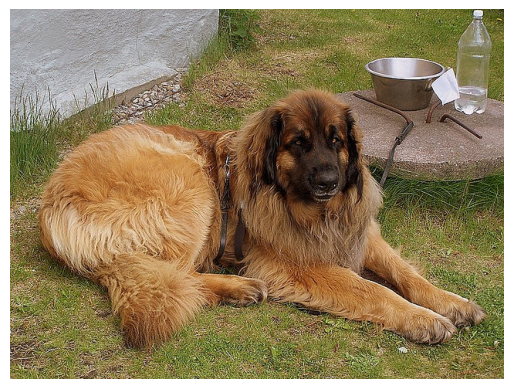

Hello, dog!
You look like a ...
	Leonberger: 99.57% 
	Anatolian shepherd dog: 0.12% 
	Saint bernard: 0.08% 
 




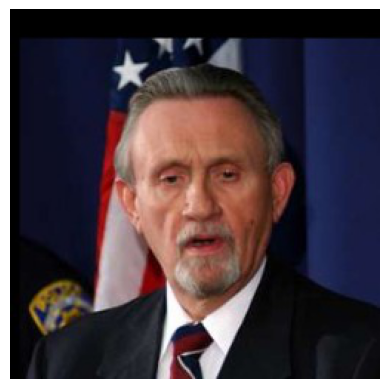

Hello, human!
You look like a ...
	Norwich terrier: 10.64% 
	Norfolk terrier: 8.62% 
	Silky terrier: 6.73% 
 




In [51]:
print("Let's see it in action! Dogs and tennis players...")
test_images = np.array(glob("/content/drive/MyDrive/AI/test/*"))
for test_image in test_images:
    run_app(test_image)